# ASO Data Extraction + Model Training
Tony Cannistra | Feb 2018

---
We'll try to use information from the ASO to train the models. Not 100% sure how to do this. 

Here's an idea for a workflow: 

1. **Download** ASO snow cover raster. 
2. **Extract** mask from raster where there's a large enough snow depth to likely have a signal (*what's the threshold?*)
3. **Search and Download** pixels from Planet from mask. 
4. **Train model** using all pixels from masked image (they all contain snow?)

Here Goes. 

In [68]:
import requests
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.features import shapes
from rasterio.plot import show
from shapely.geometry import shape, Polygon, Point
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 70
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

## 1 + 2: Check out ASO Raster + Get Mask

In [35]:
YEAR = 2017

In [36]:
asodb = "../data/aso-urls.csv"

asourls = pd.read_csv(asodb, parse_dates=[0]).set_index('date')
image = asourls[asourls.index.year == YEAR].iloc[0]

asoImage = rio.open(image.url)

In [37]:
asoData = asoImage.read(1).astype('float32')

In [38]:
asoData[asoData == -9999] = 0

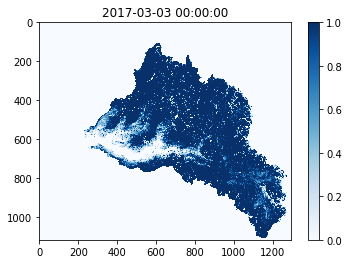

In [39]:
plt.imshow(asoData.astype('float32'), cmap="Blues", vmax=1, )
plt.title(image.name)
plt.colorbar()


In [40]:
geoms = [shape(s[0]) for s in shapes((asoData > 0).astype('int16'), transform=asoImage.transform)]
geoms = gpd.GeoDataFrame(geometry=geoms)
geoms.geometry = geoms.geometry.buffer(0) # self-intersection issues
geoms.crs = asoImage.crs
geoms['id'] = geoms.index
geoms['area'] = geoms.geometry.area
geoms = geoms.sort_values('area', ascending=False)
geoms = geoms.to_crs(ccrs.PlateCarree().proj4_init)
bounds = geoms.cascaded_union.bounds

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/rasterio/features.py:102: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


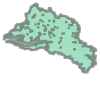

In [41]:
geoms.iloc[1].geometry

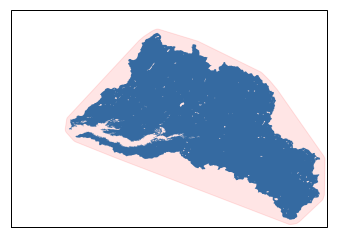

In [42]:
thisgeom = geoms.iloc[1].geometry
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
ax.set_extent(extent)
ax.add_geometries([thisgeom.buffer(0)], crs=ccrs.PlateCarree())
chull = thisgeom.convex_hull
ax.add_geometries([chull.buffer(0.01)], color='red', crs=ccrs.PlateCarree(), alpha=0.1)


## 2: Search Planet API for Imagery 
Let's see if AOI is too pointy

In [43]:
from image_utils.search import Search

In [50]:
geomidx = geoms.iloc[0].name
locgdf = geoms[geoms.index == geomidx]
locgdf['geometry'] = locgdf.geometry
start_date = image.name 
end_date = start_date + timedelta(days=5)
datedf = pd.DataFrame([pd.Series({
    'id' : geomidx, 
    'start_date' : start_date, 
    'end_date' : end_date})])

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
s = Search(locgdf, datedf)

In [52]:
results = s.query()

Querying Planet API: 100%|██████████| 1/1 [00:08<00:00,  8.81s/searches]


Text(0.5,1,'2017-03-03 00:00:00-2017-03-08 00:00:00')

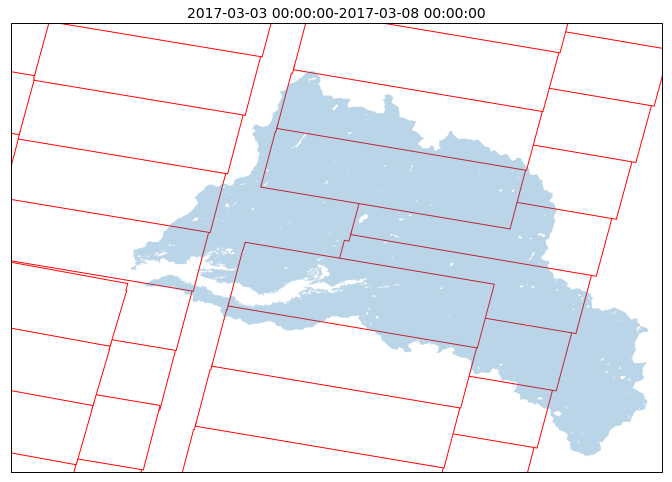

In [71]:
ax = plt.axes(projection=ccrs.PlateCarree())
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
ax.set_extent(extent)
ax.add_geometries([shape(s) for s in results.geometry], crs=ccrs.PlateCarree(), facecolor='white', edgecolor='Red')
ax.add_geometries([thisgeom], crs=ccrs.PlateCarree(), alpha=0.3)
ax.set_title("{!s}-{!s}".format(start_date, end_date))